In [110]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

##Import any other packages you may need here
from skimage import io
from itertools import chain
import pydicom

EDA is open-ended, and it is up to you to decide how to look at different ways to slice and dice your data. A good starting point is to look at the requirements for the FDA documentation in the final part of this project to guide (some) of the analyses you do. 

This EDA should also help to inform you of how pneumonia looks in the wild. E.g. what other types of diseases it's commonly found with, how often it is found, what ages it affects, etc. 

Note that this NIH dataset was not specifically acquired for pneumonia. So, while this is a representation of 'pneumonia in the wild,' the prevalence of pneumonia may be different if you were to take only chest x-rays that were acquired in an ER setting with suspicion of pneumonia. 

Perform the following EDA:
* The patient demographic data such as gender, age, patient position,etc. (as it is available)
* The x-ray views taken (i.e. view position)
* The number of cases including: 
    * number of pneumonia cases,
    * number of non-pneumonia cases
* The distribution of other diseases that are comorbid with pneumonia
* Number of disease per patient 
* Pixel-level assessments of the imaging data for healthy & disease states of interest (e.g. histograms of intensity values) and compare distributions across diseases.

Note: use full NIH data to perform the first a few EDA items and use `sample_labels.csv` for the pixel-level assassements. 

Also, **describe your findings and how will you set up the model training based on the findings.**

In [111]:
## Below is some helper code to read data for you.
## Load NIH data
all_xray_df = pd.read_csv('/data/Data_Entry_2017.csv')
all_xray_df.sample(3)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11
33718,00008841_040.png,No Finding,40,8841,50,F,PA,2992,2991,0.143,0.143,NaN
112012,00030733_000.png,No Finding,0,30733,26,F,AP,3056,2544,0.139,0.139,NaN
66522,00016443_003.png,No Finding,3,16443,46,M,PA,2992,2991,0.143,0.143,NaN


In [112]:
## Load 'sample_labels.csv' data for pixel level assessments
sample_df = pd.read_csv('sample_labels.csv')
sample_df.sample(3)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y
176,00001006_026.png,No Finding,26,1006,022Y,M,AP,2500,2048,0.168,0.168
1033,00005400_008.png,Infiltration,8,5400,035Y,M,AP,2500,2048,0.171,0.171
3261,00016094_000.png,No Finding,0,16094,024Y,M,PA,2500,2048,0.168,0.168


In [113]:
all_image_paths = {os.path.basename(x): x for x in 
                   glob(os.path.join('/data','images*', '*', '*.png'))}
print('Scans found:', len(all_image_paths), ', Total Headers', sample_df.shape[0])
sample_df['path'] = sample_df['Image Index'].map(all_image_paths.get)
sample_df.sample(3)

Scans found: 112120 , Total Headers 5606


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y,path
2960,00014570_000.png,Mass,0,14570,043Y,F,PA,2826,2581,0.143,0.143,/data/images_007/images/00014570_000.png
701,00003649_001.png,No Finding,1,3649,050Y,M,AP,3056,2544,0.139,0.139,/data/images_002/images/00003649_001.png
1292,00006763_002.png,No Finding,2,6763,013Y,M,PA,2048,2500,0.171,0.171,/data/images_004/images/00006763_002.png


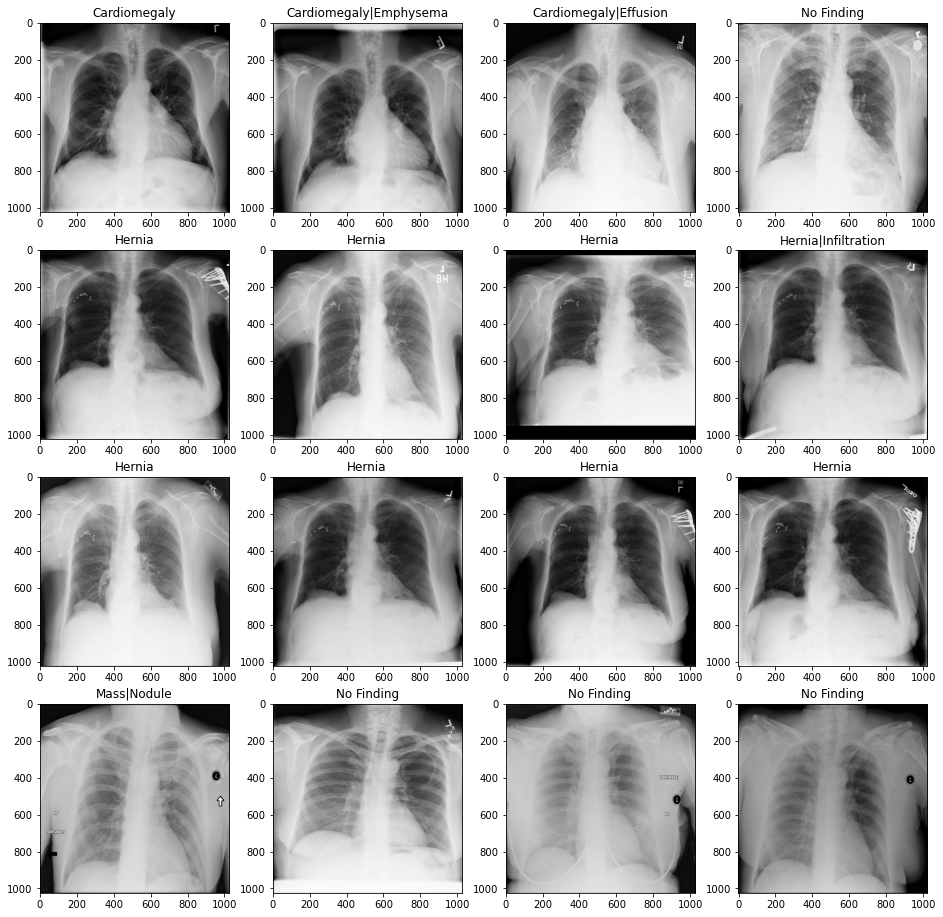

In [114]:
# Visualize medical images 
fig, m_axs = plt.subplots(4,4, figsize = (16, 16))
m_axs = m_axs.flatten()
imgs = all_xray_df['Image Index']
ind = 0

for img, ax in zip(imgs, m_axs):
    img = io.imread(all_image_paths[img])
    ax.imshow(img,cmap='gray')
    ax.set_title(all_xray_df.iloc[ind]['Finding Labels'])
    ind = ind + 1

In [115]:
all_xray_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112120 entries, 0 to 112119
Data columns (total 12 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   Image Index                  112120 non-null  object 
 1   Finding Labels               112120 non-null  object 
 2   Follow-up #                  112120 non-null  int64  
 3   Patient ID                   112120 non-null  int64  
 4   Patient Age                  112120 non-null  int64  
 5   Patient Gender               112120 non-null  object 
 6   View Position                112120 non-null  object 
 7   OriginalImage[Width          112120 non-null  int64  
 8   Height]                      112120 non-null  int64  
 9   OriginalImagePixelSpacing[x  112120 non-null  float64
 10  y]                           112120 non-null  float64
 11  Unnamed: 11                  0 non-null       float64
dtypes: float64(3), int64(5), object(4)
memory usage: 10.3+ MB


In [116]:
df_xray_clean = all_xray_df.drop('Unnamed: 11', axis=1)

In [117]:
df_xray_clean.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y]
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,0.143
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,0.171
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,0.143


In [118]:
df_xray_clean.describe()

,Follow-up #,Patient ID,Patient Age,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y]
count,112120.000000,112120.000000,112120.000000,112120.000000,112120.000000,112120.000000,112120.000000
mean,8.573751,14346.381743,46.901463,2646.078844,2486.438842,0.155649,0.155649
std,15.406320,8403.876972,16.839923,341.246429,401.268227,0.016174,0.016174
min,0.000000,1.000000,1.000000,1143.000000,966.000000,0.115000,0.115000
25%,0.000000,7310.750000,35.000000,2500.000000,2048.000000,0.143000,0.143000
50%,3.000000,13993.000000,49.000000,2518.000000,2544.000000,0.143000,0.143000
75%,10.000000,20673.000000,59.000000,2992.000000,2991.000000,0.168000,0.168000
max,183.000000,30805.000000,414.000000,3827.000000,4715.000000,0.198800,0.198800


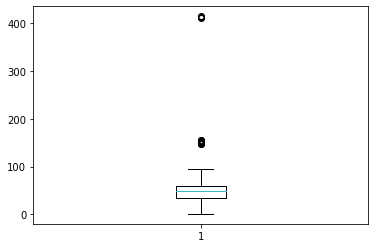

In [119]:
plt.boxplot(df_xray_clean['Patient Age']);

In [120]:
#Adjust Age data
df_xray_clean = df_xray_clean[df_xray_clean['Patient Age'] <= 100]

In [121]:
from itertools import chain
all_labels = np.unique(list(chain(*df_xray_clean['Finding Labels'].map(lambda x: x.split('|')).tolist())))
all_labels = [x for x in all_labels if len(x)>0]
print('All Labels ({}): {}'.format(len(all_labels), all_labels))

All Labels (15): ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'No Finding', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']


In [122]:
for c_label in all_labels:
    if len(c_label)>1: # leave out empty labels
        df_xray_clean[c_label] = df_xray_clean['Finding Labels'].map(lambda finding: 1.0 if c_label in finding else 0)
        sample_df[c_label] = sample_df['Finding Labels'].map(lambda finding: 1.0 if c_label in finding else 0)
df_xray_clean.sample(3)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
42934,00011062_011.png,No Finding,11,11062,43,M,AP,2500,2048,0.168,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
99304,00026263_003.png,Effusion|Mass,3,26263,38,M,PA,2992,2991,0.143,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
18654,00004950_001.png,Atelectasis|Effusion|Pneumothorax,1,4950,60,M,PA,2048,2500,0.171,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [123]:
sample_df.sample(3)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
4335,00021362_005.png,Effusion|Infiltration|Nodule|Pneumothorax,5,21362,058Y,F,PA,2706,2991,0.143,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
3281,00016205_005.png,Effusion|Infiltration,5,16205,054Y,F,PA,2990,2991,0.143,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1313,00006906_020.png,Pleural_Thickening,20,6906,069Y,M,AP,2500,2048,0.168,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [124]:
df_xray_clean['Pneumonia'].sum(), df_xray_clean['Pneumonia'].mean()

(1430.0, 0.012756012274316705)

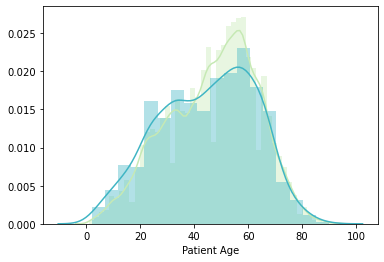

In [125]:
# Age distribution for entire dataset
sns.distplot(df_xray_clean['Patient Age']);
sns.distplot(df_xray_clean.loc[df_xray_clean.Pneumonia==1, 'Patient Age']);

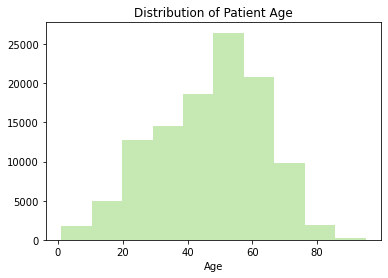

In [126]:
plt.hist(df_xray_clean['Patient Age']);
plt.title('Distribution of Patient Age');
plt.xlabel('Age');

## Finding Labels

In [127]:
df_xray_with_labels = df_xray_clean[df_xray_clean['No Finding'] == 0]
df_xray_with_labels.shape

(51751, 26)

In [128]:
# Follow up Number
df_xray_with_labels['Follow-up #'].describe()

count    51751.000000
mean        11.504628
std         17.874232
min          0.000000
25%          1.000000
50%          5.000000
75%         14.000000
max        183.000000
Name: Follow-up #, dtype: float64

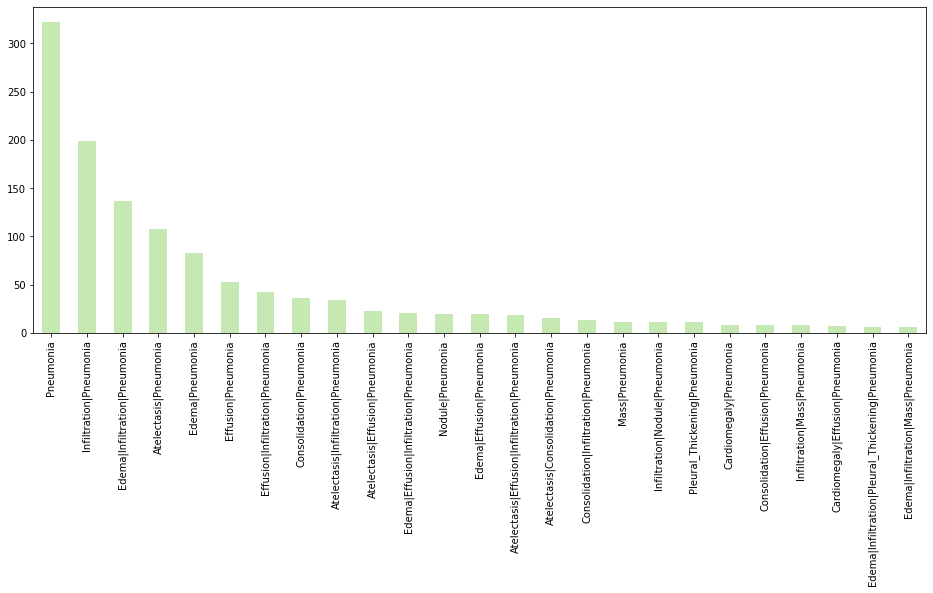

In [129]:
##We will be looking at the 25 most common co-occurrences:
plt.figure(figsize=(16,6))
df_xray_clean[df_xray_clean.Pneumonia==1]['Finding Labels'].value_counts()[:25].plot(kind='bar');
#plt.title('Pneumonia appearances');

In [130]:
# Number of Pneumonia
numPneumonia = int(df_xray_clean['Pneumonia'].sum())
ratePneumonia = 100*df_xray_clean['Pneumonia'].mean()
print('Number of Pneumonia cases: {} ({:.4f}%)'.format(numPneumonia, ratePneumonia))
print('Number of non-Pneumonia cases: {} ({:.4f}%)'.format(df_xray_clean.shape[0] /
                                                           - numPneumonia, 100 - ratePneumonia))

Number of Pneumonia cases: 1430 (1.2756%)
Number of non-Pneumonia cases: -78.3944055944056 (98.7244%)


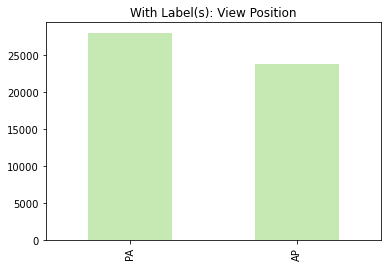

In [131]:
# View Position
df_xray_with_labels['View Position'].value_counts().plot(kind="bar");
plt.title('With Label(s): View Position');

In [132]:
# Number of Pneumonia
numPneumonia = int(df_xray_with_labels['Pneumonia'].sum())
ratePneumonia = 100*df_xray_with_labels['Pneumonia'].mean()
print('With Label(s) - Number of Pneumonia cases: {} ({:.4f}%)'.format(numPneumonia, ratePneumonia))
print('With Label(s) - Number of non-Pneumonia cases: {} ({:.4f}%)'.format(df_xray_with_labels.shape[0] /
                                                                           - numPneumonia, 100 - ratePneumonia))

With Label(s) - Number of Pneumonia cases: 1430 (2.7632%)
With Label(s) - Number of non-Pneumonia cases: -36.18951048951049 (97.2368%)


## Gender

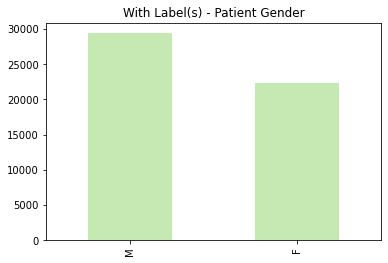

In [133]:
df_xray_with_labels['Patient Gender'].value_counts().plot(kind="bar");
plt.title('With Label(s) - Patient Gender');

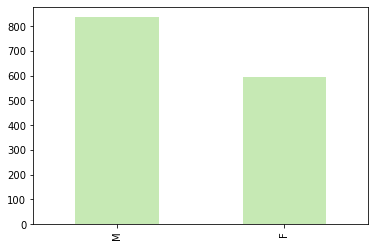

In [134]:
df_xray_with_labels[df_xray_with_labels.Pneumonia==1]['Patient Gender'].value_counts().plot(kind='bar');

The data contains more male samples than female. There are also more male samples of patients which are Pneumonia positive.

## Pixel Level Assessment

In [135]:
import os
print(os.listdir("//data/"))

['FAQ_CHESTXRAY.pdf', 'ARXIV_V5_CHESTXRAY.pdf', 'images_009', 'images_011', 'images_003', 'images_004', 'README_CHESTXRAY.pdf', 'images_012', 'images_007', 'images_005', 'train_val_list.txt', 'BBox_List_2017.csv', 'images_001', 'images_008', 'LOG_CHESTXRAY.pdf', 'images_006', 'test_list.txt', 'images_002', 'images_010', 'Data_Entry_2017.csv']


In [136]:
# Loading sample data
images = []
for i, img_id in enumerate(sample_df['Image Index']):
    path = glob(os.path.join("../../data","images*","*",img_id))[0]
    img = io.imread(path)
    images.append(img)
print("Loaded {}/{}".format(i+1, len(sample_df)))

Loaded 5606/5606


In [137]:
intensity_images = []
for i, image in enumerate(images):
    intensity_images.append(np.mean(image))
intensity_images = np.array(intensity_images)
print("Done {}/{}".format(i, len(images)))

Done 5605/5606


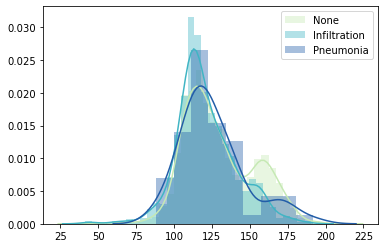

In [138]:
sns.set_palette("YlGnBu", 3)
pneumonia_intensity = intensity_images[sample_df[sample_df["Finding Labels"].str.contains("Pneumonia")].index]
infiltration_intensity = intensity_images[sample_df[sample_df["Finding Labels"].str.contains("Infiltration")].index]
no_finding_intensity = intensity_images[sample_df[sample_df["Finding Labels"].str.contains("No Finding")].index]
sns.distplot(no_finding_intensity,label = "None");
sns.distplot(infiltration_intensity, label = "Infiltration");
sns.distplot(pneumonia_intensity, label = "Pneumonia");
plt.legend();

At about 150-175, there is a difference in intensity in healthy scans and scans that show Pneumonia.